In [1]:
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
import numpy  as np
from numpy import set_printoptions
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import Normalizer,StandardScaler
from sklearn.feature_selection import SelectKBest,chi2, RFE
from pandas.plotting import scatter_matrix
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_absolute_error as mae
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import ElasticNet
from sklearn.linear_model import Lasso
from sklearn.linear_model import Ridge

from sklearn import linear_model

data1 = pd.read_csv("C:/Datasets/diamonds.csv")

In [2]:
data1.columns

Index(['Unnamed: 0', 'carat', 'cut', 'color', 'clarity', 'depth', 'table',
       'price', 'x', 'y', 'z'],
      dtype='object')

In [3]:
data = data1.loc[:,['carat', 'cut', 'color', 'clarity', 'depth', 'table',
       'price', 'x', 'y', 'z']]

In [4]:
data.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 53940 entries, 0 to 53939
Data columns (total 10 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   carat    53940 non-null  float64
 1   cut      53940 non-null  object 
 2   color    53940 non-null  object 
 3   clarity  53940 non-null  object 
 4   depth    53940 non-null  float64
 5   table    53940 non-null  float64
 6   price    53940 non-null  int64  
 7   x        53940 non-null  float64
 8   y        53940 non-null  float64
 9   z        53940 non-null  float64
dtypes: float64(6), int64(1), object(3)
memory usage: 4.1+ MB


In [5]:
data.isna().sum()

carat      0
cut        0
color      0
clarity    0
depth      0
table      0
price      0
x          0
y          0
z          0
dtype: int64

In [6]:
#feature encoding
sorted(data.cut.unique())

['Fair', 'Good', 'Ideal', 'Premium', 'Very Good']

In [7]:
sorted(data.color.unique())

['D', 'E', 'F', 'G', 'H', 'I', 'J']

In [8]:
sorted(data.clarity.unique())

['I1', 'IF', 'SI1', 'SI2', 'VS1', 'VS2', 'VVS1', 'VVS2']

In [9]:
dataEncode = data.copy()

In [10]:
dataEncode['cut'] = dataEncode.cut.replace({'Fair':1, 'Good':2, 'Very Good':3,'Ideal':4, 'Premium':5})
dataEncode['color'] =dataEncode.color.replace({'D':1, 'E':2, 'F':3, 'G':4, 'H':5, 'I':6, 'J':7})
dataEncode['clarity'] =dataEncode.clarity.replace({'I1':1, 'IF':2, 'SI1':3, 'SI2':4, 'VS1':5, 'VS2':6, 'VVS1':7, 'VVS2':8})

In [11]:
dataEncode

,carat,cut,color,clarity,depth,table,price,x,y,z
0,0.23,4,2,4,61.5,55.0,326,3.95,3.98,2.43
1,0.21,5,2,3,59.8,61.0,326,3.89,3.84,2.31
2,0.23,2,2,5,56.9,65.0,327,4.05,4.07,2.31
3,0.29,5,6,6,62.4,58.0,334,4.20,4.23,2.63
4,0.31,2,7,4,63.3,58.0,335,4.34,4.35,2.75
...,...,...,...,...,...,...,...,...,...,...
53935,0.72,4,1,3,60.8,57.0,2757,5.75,5.76,3.50
53936,0.72,2,1,3,63.1,55.0,2757,5.69,5.75,3.61
53937,0.70,3,1,3,62.8,60.0,2757,5.66,5.68,3.56
53938,0.86,5,5,4,61.0,58.0,2757,6.15,6.12,3.74


# Data Cleaning

In [12]:
#removing Duplicate
dupData = dataEncode.duplicated(keep='first')
cleanData = dataEncode[~dupData]
cleanData

,carat,cut,color,clarity,depth,table,price,x,y,z
0,0.23,4,2,4,61.5,55.0,326,3.95,3.98,2.43
1,0.21,5,2,3,59.8,61.0,326,3.89,3.84,2.31
2,0.23,2,2,5,56.9,65.0,327,4.05,4.07,2.31
3,0.29,5,6,6,62.4,58.0,334,4.20,4.23,2.63
4,0.31,2,7,4,63.3,58.0,335,4.34,4.35,2.75
...,...,...,...,...,...,...,...,...,...,...
53935,0.72,4,1,3,60.8,57.0,2757,5.75,5.76,3.50
53936,0.72,2,1,3,63.1,55.0,2757,5.69,5.75,3.61
53937,0.70,3,1,3,62.8,60.0,2757,5.66,5.68,3.56
53938,0.86,5,5,4,61.0,58.0,2757,6.15,6.12,3.74


In [13]:
#removing outliers
def Outliers(data,feature):
    IQ1 = data[feature].quantile(0.25) # identify 25%
    IQ3 = data[feature].quantile(0.75) # identify 75% 
    IQR = IQ3 - IQ1 # identify the range
    
    lowerBound = IQ1 - 1.5 * IQR
    upperBound = IQ3 + 1.5 * IQR
    
    index = data. index[ (data[feature] < lowerBound) | (data[feature] > upperBound) ]
    
    return index

In [14]:
#getting index of all the outliers
index = []
for i in cleanData.columns: # goes through all colums in the dataset
    index.extend(Outliers(cleanData, i))# this passes dataset and the column of interest
index = set(index)
print('Total number of outliers are {}'.format(len(index)))

#Dropping all the outliers
cleanData. drop(index, inplace = True, axis = 0)
cleanData.shape
#df.head(20)- to select top 20 feature

Total number of outliers are 6378


C:\Users\APINPC\anaconda3\lib\site-packages\pandas\core\frame.py:4906: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


(47416, 10)

In [15]:
cleanData

,carat,cut,color,clarity,depth,table,price,x,y,z
0,0.23,4,2,4,61.5,55.0,326,3.95,3.98,2.43
1,0.21,5,2,3,59.8,61.0,326,3.89,3.84,2.31
3,0.29,5,6,6,62.4,58.0,334,4.20,4.23,2.63
4,0.31,2,7,4,63.3,58.0,335,4.34,4.35,2.75
5,0.24,3,7,8,62.8,57.0,336,3.94,3.96,2.48
...,...,...,...,...,...,...,...,...,...,...
53935,0.72,4,1,3,60.8,57.0,2757,5.75,5.76,3.50
53936,0.72,2,1,3,63.1,55.0,2757,5.69,5.75,3.61
53937,0.70,3,1,3,62.8,60.0,2757,5.66,5.68,3.56
53938,0.86,5,5,4,61.0,58.0,2757,6.15,6.12,3.74


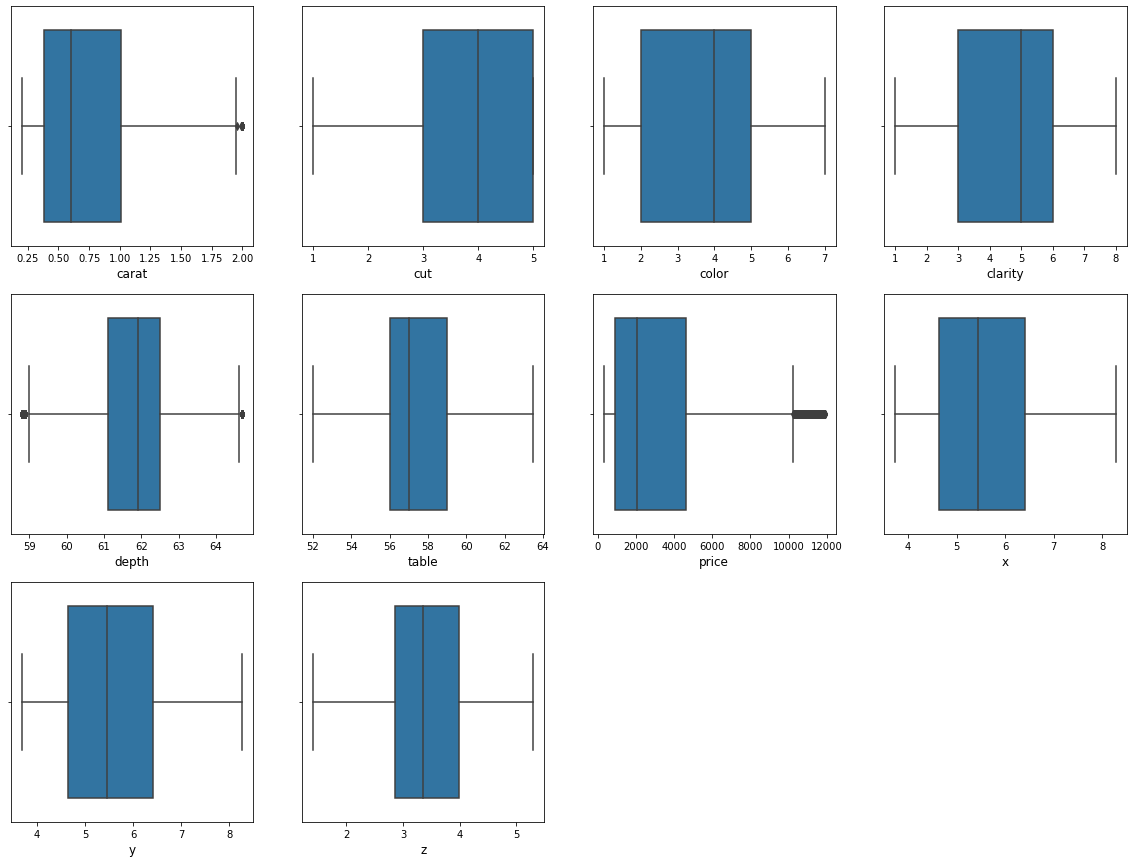

In [16]:
# checking for outliers
plt.figure(figsize=(20, 15))
for i in range(len(cleanData.columns)):
    plt.subplot(3,4,i+1)
    sns.boxplot(x =cleanData.iloc[:, i])
    plt.xlabel(cleanData.columns[i], size =12)

# Data Transformation

In [17]:
#seperate Outcome variabele from input variable
outVar = cleanData.price 
inVar = cleanData.drop(['price'],axis=1)

In [18]:
xArray = inVar.values
Y = outVar.values
demo= MinMaxScaler(feature_range=(0,1))
rescaledX= demo.fit_transform(X=xArray)
rescaledXdf = pd.DataFrame(rescaledX)
rescaledXdf.columns = ['carat', 'cut', 'color', 'clarity', 'depth', 'table',
        'x', 'y', 'z']
rescaledXdf['price'] = Y
rescaledXdf

,carat,cut,color,clarity,depth,table,x,y,z,price
0,0.016667,0.75,0.166667,0.428571,0.457627,0.260870,0.048352,0.065359,0.262211,326
1,0.005556,1.00,0.166667,0.285714,0.169492,0.782609,0.035165,0.034858,0.231362,326
2,0.050000,1.00,0.833333,0.714286,0.610169,0.521739,0.103297,0.119826,0.313625,334
3,0.061111,0.25,1.000000,0.428571,0.762712,0.521739,0.134066,0.145969,0.344473,335
4,0.022222,0.50,1.000000,1.000000,0.677966,0.434783,0.046154,0.061002,0.275064,336
...,...,...,...,...,...,...,...,...,...,...
47411,0.288889,0.75,0.000000,0.285714,0.338983,0.434783,0.443956,0.453159,0.537275,2757
47412,0.288889,0.25,0.000000,0.285714,0.728814,0.260870,0.430769,0.450980,0.565553,2757
47413,0.277778,0.50,0.000000,0.285714,0.677966,0.695652,0.424176,0.435730,0.552699,2757
47414,0.366667,1.00,0.666667,0.428571,0.372881,0.521739,0.531868,0.531590,0.598972,2757


In [19]:
#normalize
array = rescaledXdf.values
# seperate array into input and output outcomes
 
X = array[0:, 0:9]
Y = array[:,9]
scaler = Normalizer().fit(X)
normalizedX= scaler.transform(X)
normDF =pd.DataFrame(normalizedX, columns = ['carat', 'cut', 'color', 'clarity', 'depth', 'table','x', 'y', 'z'])
normDF['price'] = Y
normDF

,carat,cut,color,clarity,depth,table,x,y,z,price
0,0.015699,0.706458,0.156991,0.403690,0.431059,0.245724,0.045545,0.061565,0.246988,326.0
1,0.004133,0.743988,0.123998,0.212568,0.126100,0.582252,0.026162,0.025934,0.172131,326.0
2,0.028988,0.579766,0.483138,0.414118,0.353755,0.302486,0.059888,0.069471,0.181829,334.0
3,0.040634,0.166232,0.664927,0.284969,0.507147,0.346918,0.089144,0.097059,0.229049,335.0
4,0.012872,0.289609,0.579218,0.579218,0.392690,0.251834,0.026733,0.035334,0.159322,336.0
...,...,...,...,...,...,...,...,...,...,...
47411,0.220106,0.571430,0.000000,0.217688,0.258273,0.331264,0.338253,0.345265,0.409353,2757.0
47412,0.233126,0.201744,0.000000,0.230564,0.588134,0.210515,0.347620,0.363930,0.456387,2757.0
47413,0.195076,0.351137,0.000000,0.200650,0.476117,0.488538,0.297887,0.306001,0.388146,2757.0
47414,0.208318,0.568140,0.378760,0.243489,0.211849,0.296421,0.302176,0.302018,0.340300,2757.0


In [20]:
normDF.columns

Index(['carat', 'cut', 'color', 'clarity', 'depth', 'table', 'x', 'y', 'z',
       'price'],
      dtype='object')

# feature Selection

In [21]:
# UNIVARIATE FEATURE SELECTION

normArray=normDF.values
# seperate the array

X = normArray[:,0:9]

Y = normArray[:,9]
#feature Extraction
test1 = SelectKBest(score_func=chi2, k=5)
test = test1.fit(X, Y) # check relationship of input vairiabele with the output variable and score
set_printoptions(precision=3)

print(test.scores_)

Features = test.transform(X)
selectedFeatures =pd.DataFrame(Features)
selectedFeatures.columns =['carat', 'color', 'clarity', 'x', 'y']
selectedFeatures


[2765.735  827.415 1628.312 1535.187  675.698  445.487 1981.901 1849.103
  466.725]


,carat,color,clarity,x,y
0,0.015699,0.156991,0.403690,0.045545,0.061565
1,0.004133,0.123998,0.212568,0.026162,0.025934
2,0.028988,0.483138,0.414118,0.059888,0.069471
3,0.040634,0.664927,0.284969,0.089144,0.097059
4,0.012872,0.579218,0.579218,0.026733,0.035334
...,...,...,...,...,...
47411,0.220106,0.000000,0.217688,0.338253,0.345265
47412,0.233126,0.000000,0.230564,0.347620,0.363930
47413,0.195076,0.000000,0.200650,0.297887,0.306001
47414,0.208318,0.378760,0.243489,0.302176,0.302018


In [22]:
# Recursive Elimination Technique
array=normDF.values
X = array[0:10000, 0:9] # i had to reduce sample size because the dataset is large
Y = array[0:10000, 9]
model = LogisticRegression(max_iter = 20000)
rfe=RFE(model,n_features_to_select=5)
fit = rfe.fit(X, Y)
print("Num Features: {}".format(fit.n_features_)) 
print("Selected Features: {}".format(fit.support_))
print("Feature Ranking: {}".format(fit.ranking_)) 

subsetCols1 = ['carat', 'color', 'clarity', 'x', 'y']

rfeSelectedDF = normDF[subsetCols1]
rfeSelectedDF

Num Features: 5
Selected Features: [ True False  True  True False False  True  True False]
Feature Ranking: [1 2 1 1 3 4 1 1 5]


,carat,color,clarity,x,y
0,0.015699,0.156991,0.403690,0.045545,0.061565
1,0.004133,0.123998,0.212568,0.026162,0.025934
2,0.028988,0.483138,0.414118,0.059888,0.069471
3,0.040634,0.664927,0.284969,0.089144,0.097059
4,0.012872,0.579218,0.579218,0.026733,0.035334
...,...,...,...,...,...
47411,0.220106,0.000000,0.217688,0.338253,0.345265
47412,0.233126,0.000000,0.230564,0.347620,0.363930
47413,0.195076,0.000000,0.200650,0.297887,0.306001
47414,0.208318,0.378760,0.243489,0.302176,0.302018


In [23]:
#checking for the best technique for feature selection
dfUnivar = selectedFeatures

dfRfe = rfeSelectedDF

In [27]:
#Univariate Model 

X = dfUnivar.values# selected input variable
#X = X1[0:10000, 0:9] 
Y =  array[:,9] # outcome variable
num_folds = 10
kfold = KFold(n_splits=num_folds) # shuffle = True, random_state=10

model =LinearRegression()

results = cross_val_score(model, X, Y, cv=kfold)
accuracy = np.mean(results)
print('model accuracy is: ',results)
print('model accuracy is: ',accuracy)

'''
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.30, random_state=42)
model = LinearRegression() # blank model

model.fit(X_train, y_train)

ScoreTrain = model.score(X_train, y_train)
ScoreTest = model.score(X_test, y_test)

ScoreTest'''


model accuracy is:  [-5.629e-02  1.520e-02  5.985e-01  5.696e-01  7.279e-01 -2.110e+01
 -1.858e+01 -4.214e+00 -3.168e-01 -4.678e-01]
model accuracy is:  -4.28238631473217


'\n\nX_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.30, random_state=42)\nmodel = LinearRegression() # blank model\n\nmodel.fit(X_train, y_train)\n\nScoreTrain = model.score(X_train, y_train)\nScoreTest = model.score(X_test, y_test)\n\nScoreTest'

In [25]:
X = dfRfe.values # selected input variable
Y =  array[:,9] # outcome variable
'''num_folds = 10
kfold = KFold(n_splits=num_folds) # shuffle = True, random_state=10

model =LinearRegression()

results = cross_val_score(model, X, Y, cv=kfold)
accuracy = np.mean(results)

print('model accuracy is: {}'.format(accuracy*100.0))'''
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.30, random_state=42)
model = LinearRegression() # blank model

model.fit(X_train, y_train)

ScoreTrain = model.score(X_train, y_train)
ScoreTest = model.score(X_test, y_test)
ScoreTest

0.8677275451442824

from the above feature selection technique, it is seen that both Univariate technique and  recursive elimination technique selected the same feature given us an appr. 87% accuracy

# Model Building

#since price variable is our output variable and this variable grows or reduces in a linear format so we will  use linear regression algorithm

In [26]:

X = dfRfe.values
Y = array[:,9]

#numFolds = 10

models = []
models.append(('LR', LinearRegression()))
models.append(('EN', ElasticNet()))
models.append(('LS', Lasso()))
models.append(('R', Ridge()))
#models.append(('SVC', SVC()))
#models.append(('DTC', DecisionTreeClassifier()))
#models.append(('KNN', KNeighborsClassifier()))


# evaluate each model in turn
trainResults = []
testResults = []
names = []
scoring = 'accuracy'
for name, model in models:
    X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.30, random_state=42)
    model.fit(X_train, y_train)
    ScoreTrain = model.score(X_train, y_train)
    ScoreTest = model.score(X_test, y_test)
    trainResults.append(ScoreTrain)
    testResults.append(ScoreTest)
    names.append(name)
    msg = (name, ScoreTrain, ScoreTest, ScoreTest-ScoreTrain)
    print(msg)


('LR', 0.8675299315697031, 0.8677275451442824, 0.00019761357457925843)
('EN', 0.0889137326938203, 0.08906124705471008, 0.00014751436088977776)
('LS', 0.8665783974374177, 0.8668763777766888, 0.0002979803392710867)
('R', 0.8667070079138268, 0.8670818848934418, 0.0003748769796150242)


Based on th above outcome, it shows that for all the 4 algorithms used, there is an improvement on the model performance after training and there is no issue of overfitting across all four model. The algorithm with the highest improvement is the Ridge Algorithm, followed by Lasso, then Linear Regression and finally ElasticNet alogrithm